In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import datasets

# 1. Загружаем данные из csv

In [24]:
# Первый столбец - индекс, учтем
data = pd.read_csv('custom_dataset.csv', index_col=0)
data.dropna()
print(data.shape)

(4096, 3)


In [4]:
data.head(17)

,feature_1,feature_2,target
0,0.027957,0.856195,0
1,-0.452472,0.880457,0
2,0.006996,0.815738,0
3,-0.721376,0.992746,0
4,-0.104573,0.831477,0
5,1.003088,0.460751,0
6,-0.723817,0.501823,0
7,0.766279,0.425483,0
8,1.835688,0.377939,1
9,-1.266677,0.454915,0


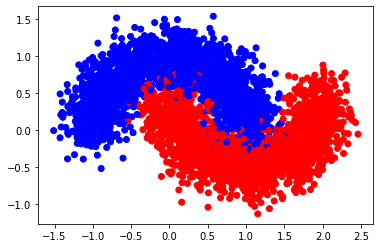

In [5]:
fig, ax = plt.subplots()
colors = []
for i in data['target'].to_numpy():
    if i == 0:
        colors.append('blue')
    else:
        colors.append('red')
ax.scatter(data['feature_1'].to_numpy(), data['feature_2'].to_numpy(), c = colors)

Просматривается что-то похожее на синус. А точнее, разделяющая кривая, возможно, имеет форму $ y = -sin (\pi \cdot x) + 0.5 $

Использовать обратный синус не очень хочется, а что будет если, например, на $y$ тоже натравить синус?

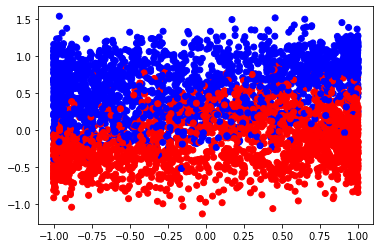

In [6]:
fig, ax = plt.subplots()
colors = []
for i in data['target'].to_numpy():
    if i == 0:
        colors.append('blue')
    else:
        colors.append('red')
ax.scatter(np.sin(0 - data['feature_1'].to_numpy() * 3.1415 + 0.5), data['feature_2'].to_numpy(), c = colors)

Не лучшие результаты, много перекрытия, но поробуем SVM

# Задание 1. Попытка 1.

In [7]:
from sklearn.svm import SVC

In [8]:
X = np.stack((np.sin(0 - data['feature_1'].to_numpy() * 3.1415 + 0.5), data['feature_2'].to_numpy()), axis=-1)

In [9]:
y = data['target'].to_numpy()

In [10]:
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

C:\Users\user\AppData\Local\Temp/ipykernel_9712/850316495.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='autumn')


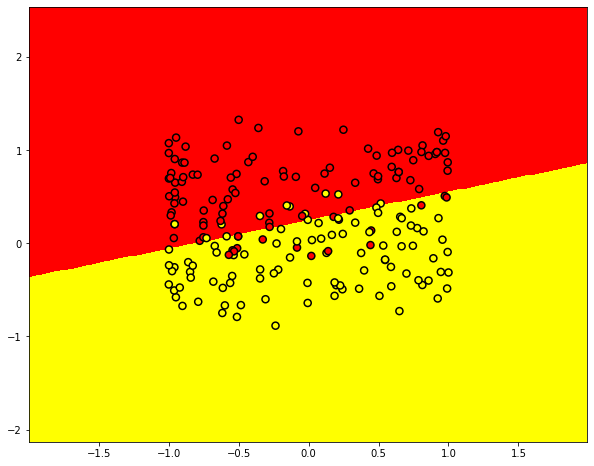

In [11]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

random_indxs = np.random.randint(0, X.shape[0], 200)

plt.rcParams['figure.figsize'] = (10,8)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[random_indxs, 0], X[random_indxs, 1], 
            c=y[random_indxs], s=50, cmap='autumn', edgecolors='black', linewidth=1.5)


Разделяющей полосы не наблюдается

# Задание 1. Попытка 2.

Необходимо также получить какие-то метрики качества предсказания, то есть поделить данные на train и test

В прошлый раз было много перекрытия в синусе. Теперь попробуем другую формулу

C:\Users\user\AppData\Local\Temp/ipykernel_9712/992748069.py:4: RuntimeWarning: invalid value encountered in arccos
  X[:,0] = np.arccos((X[:,0] - 0.15) * 3) / 8.


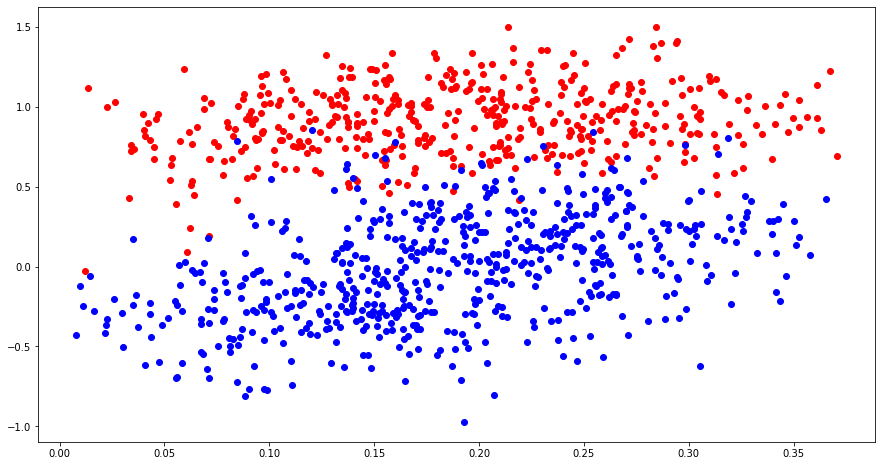

In [29]:
X = np.array(data[['feature_1', 'feature_2']])
y = np.array(data['target'])

X[:,0] = np.arccos((X[:,0] - 0.15) * 3) / 8.

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
colors = {0:'red', 1:'blue'}

for key, value in colors.items():   
    ax.scatter((X[y==key, 0]), (X[y==key, 1]), c=value, label=key)
    
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

In [30]:
X_new = np.array(data[['feature_1', 'feature_2']])
y_new = np.array(data['target'])

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.33)

In [32]:
model_new = SVC(kernel='linear')
model_new.fit(X_train_new, y_train_new)

SVC(kernel='linear')

In [37]:
predicted = model_new.predict(X_test_new)
# Метрики качества
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
print(accuracy_score(y_test_new, predicted))
print(f1_score(y_test_new, predicted))
print(roc_auc_score(y_test_new, predicted))
print(precision_score(y_test_new, predicted))
print(recall_score(y_test_new, predicted))

0.875
0.8734082397003745
0.8750270873690777
0.8701492537313433
0.8766917293233083


In [43]:
#Коэффициенты разделяющей прямой
b = model_new.intercept_[0]
ws = model_new.coef_

#расстояние от прямой до точки (x, y)
def distance(x, y, ws_, b_):
    return (np.fabs(ws_[0][0] * x + ws_[0][1] * y + b_) / np.sqrt(np.sum(ws_**2)))

x = X_test_new[:, 0]
y = X_test_new[:, 1]

#Расстояние между плоскостями
r1 = np.min(distance(x[predicted == 0], y[predicted == 0], ws, b))
r2 = np.min(distance(x[predicted == 1], y[predicted == 1], ws, b))
print(r1 + r2)

0.0007790552805360112


# Задание 2.

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
X = np.stack((data['feature_1'].to_numpy(), data['feature_2'].to_numpy()), axis=-1)
y = data['target'].to_numpy()

In [46]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

C:\Users\user\AppData\Local\Temp/ipykernel_9712/1437848233.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='autumn')


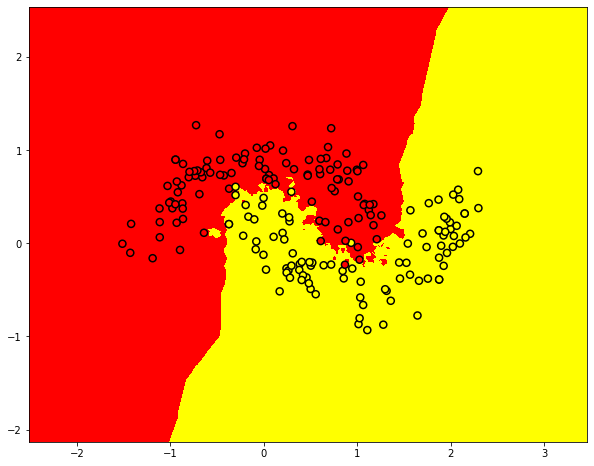

In [47]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

predicted = neigh.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

random_indxs = np.random.randint(0, X.shape[0], 200)

plt.rcParams['figure.figsize'] = (10,8)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[random_indxs, 0], X[random_indxs, 1], 
            c=y[random_indxs], s=50, cmap='autumn', edgecolors='black', linewidth=1.5)

Оценим качество. Для этого опять разделим выборку и научим новую модель

In [53]:
neigh_new = KNeighborsClassifier(n_neighbors=5) # Для эксперимента попробуем 5
neigh_new.fit(X_train_new, y_train_new)

predicted_n = neigh_new.predict(X_test_new)

print(accuracy_score(y_test_new, predicted_n))
print(f1_score(y_test_new, predicted_n))
print(roc_auc_score(y_test_new, predicted_n))
print(precision_score(y_test_new, predicted_n))
print(recall_score(y_test_new, predicted_n))

0.9637573964497042
0.9630746043707611
0.9637116809490975
0.9652567975830816
0.9609022556390977
